In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
np.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [ ]:
np.min(train_images[0]), np.max(train_images[0])

(0, 255)

In [ ]:
# Normalize pixel values between 0 and 1
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

### Section: Building a baseline model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model1 = Sequential()
model1.add(Flatten(input_shape=(28,28)))
model1.add(Dense(64, activation='sigmoid'))
model1.add(Dropout(0.2))
model1.add(Dense(10, activation='softmax'))

In [ ]:
model1.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 50890 (198.79 KB)
Trainable params: 50890 (198.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
callbacks = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [ ]:
history = model1.fit(train_images, train_labels,
                     validation_split=0.2, shuffle=True,
                     epochs=50, batch_size=256,
                     callbacks=[callbacks])

Epoch 1/50
188/188 [==============================] - 8s 5ms/step - loss: 1.1175 - accuracy: 0.6549 - val_loss: 0.6799 - val_accuracy: 0.7948
Epoch 2/50
188/188 [==============================] - 1s 4ms/step - loss: 0.6451 - accuracy: 0.7870 - val_loss: 0.5377 - val_accuracy: 0.8176
Epoch 3/50
188/188 [==============================] - 1s 4ms/step - loss: 0.5478 - accuracy: 0.8126 - val_loss: 0.4876 - val_accuracy: 0.8268
Epoch 4/50
188/188 [==============================] - 1s 4ms/step - loss: 0.5018 - accuracy: 0.8256 - val_loss: 0.4581 - val_accuracy: 0.8389
Epoch 5/50
188/188 [==============================] - 1s 6ms/step - loss: 0.4734 - accuracy: 0.8337 - val_loss: 0.4318 - val_accuracy: 0.8446
Epoch 6/50
188/188 [==============================] - 1s 5ms/step - loss: 0.4540 - accuracy: 0.8414 - val_loss: 0.4209 - val_accuracy: 0.8496
Epoch 7/50
188/188 [==============================] - 1s 5ms/step - loss: 0.4370 - accuracy: 0.8459 - val_loss: 0.4081 - val_accuracy: 0.8520
Epoch 

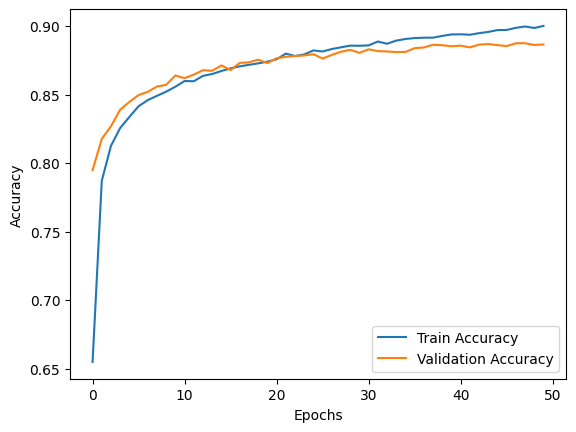

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model1.evaluate(test_images, test_labels)[1]

313/313 [==============================] - 1s 4ms/step - loss: 0.3409 - accuracy: 0.8807


0.8806999921798706

### Section: Tuning the activation function


In [ ]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 26.7 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow import keras

In [ ]:
def model_builder(hparams):

  model = Sequential()
  model.add(Flatten(input_shape=(28, 28)))

  hp_activation = hparams.Choice('activation', ['sigmoid', 'tanh', 'elu', 'relu'])
  model.add(Dense(units=64, activation=hp_activation))
  model.add(Dropout(0.2))
  model.add(Dense(units=10, activation='softmax'))

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=4,
    overwrite=True,
    seed=42)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'tanh', 'elu', 'relu'], 'ordered': False}


In [ ]:
stop_early = EarlyStopping(monitor='val_accuracy',
                           patience=10,
                           restore_best_weights=True)

In [ ]:
tuner.search(train_images, train_labels,
             validation_split=0.2,
             epochs=25, batch_size=256,
             callbacks=[stop_early])

Trial 4 Complete [00h 00m 26s]
val_accuracy: 0.887333333492279

Best val_accuracy So Far: 0.887333333492279
Total elapsed time: 00h 02m 33s


In [ ]:
res = tuner.get_best_hyperparameters()[0]
res.values

{'activation': 'relu'}

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
activation: elu
Score: 0.8964999914169312
Trial summary
Hyperparameters:
activation: sigmoid
Score: 0.8923333287239075
Trial summary
Hyperparameters:
activation: relu
Score: 0.8894166946411133
Trial summary
Hyperparameters:
activation: tanh
Score: 0.8887500166893005


In [ ]:
best_activation_model = tuner.get_best_models()[0]

In [ ]:
best_activation_model.evaluate(test_images, test_labels)[1]

313/313 [==============================] - 1s 2ms/step - loss: 0.3450 - accuracy: 0.8828


0.8827999830245972

### Section: Tuning the learning rate

In [ ]:
def model_builder(hparams):

  model = Sequential()
  model.add(Flatten(input_shape=(28, 28)))

  hp_activation = hparams.Choice('activation', ['elu', 'relu', 'tanh'])
  model.add(Dense(units=64, activation=hp_activation))
  model.add(Dropout(0.2))
  model.add(Dense(units=10, activation='softmax'))

  hp_lr = hparams.Choice('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 0.1])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=10,
    overwrite=True,
    seed=42)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
activation (Choice)
{'default': 'elu', 'conditions': [], 'values': ['elu', 'relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 1e-05, 'conditions': [], 'values': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'ordered': True}


In [ ]:
stop_early = EarlyStopping(monitor='val_accuracy',
                           patience=10,
                           restore_best_weights=True)

In [ ]:
tuner.search(train_images, train_labels, validation_split=0.2,
             epochs=25, batch_size=256,
             callbacks=[stop_early])

Trial 10 Complete [00h 00m 42s]
val_accuracy: 0.8548333048820496

Best val_accuracy So Far: 0.8852499723434448
Total elapsed time: 00h 06m 09s


In [ ]:
res = tuner.get_best_hyperparameters()[0]
res.values

{'activation': 'relu', 'learning_rate': 0.001}

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
activation: relu
learning_rate: 0.001
Score: 0.8852499723434448

Trial 05 summary
Hyperparameters:
activation: elu
learning_rate: 0.001
Score: 0.8830833435058594

Trial 06 summary
Hyperparameters:
activation: tanh
learning_rate: 0.001
Score: 0.8826666474342346

Trial 03 summary
Hyperparameters:
activation: tanh
learning_rate: 0.01
Score: 0.8701666593551636

Trial 01 summary
Hyperparameters:
activation: relu
learning_rate: 0.0001
Score: 0.856083333492279

Trial 02 summary
Hyperparameters:
activation: tanh
learning_rate: 0.0001
Score: 0.8552500009536743

Trial 09 summary
Hyperparameters:
activation: elu
learning_rate: 0.0001
Score: 0.8548333048820496

Trial 04 summary
Hyperparameters:
activation: tanh
learning_rate: 1e-05
Score: 0.7870000004768372

Trial 08 summary
Hyperparameters:
activation: elu
learning_rate: 1e-05
Score: 0.78450000286

In [ ]:
best_lr_model = tuner.get_best_models()[0]
best_lr_model.evaluate(test_images, test_labels)[1]

### Section: Tuning the number of hidden units

In [ ]:
def model_builder(hparams):

  model = Sequential()
  model.add(Flatten(input_shape=(28, 28)))

  hp_units = hparams.Int('units', min_value=32, max_value=512, step=32)
  hp_activation = hparams.Choice('activation', ['elu', 'relu'])
  model.add(Dense(units=hp_units, activation=hp_activation))
  model.add(Dropout(0.2))

  model.add(Dense(units=10, activation='softmax'))

  hp_lr = hparams.Choice('learning_rate', [1e-4, 1e-3])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=15,
    overwrite=True,
    seed=42)

In [ ]:
stop_early = EarlyStopping(monitor='val_accuracy',
                           patience=10,
                           restore_best_weights=True)

In [ ]:
tuner.search(train_images, train_labels, validation_split=0.2,
             epochs=25, batch_size=256,
             callbacks=[stop_early])

Trial 10 Complete [00h 00m 21s]
val_accuracy: 0.8521666526794434

Best val_accuracy So Far: 0.8759166598320007
Total elapsed time: 00h 06m 32s
INFO:tensorflow:Oracle triggered exit


In [ ]:
res = tuner.get_best_hyperparameters()[0]
res.values

{'activation': 'relu', 'learning_rate': 0.001, 'units': 256}

In [ ]:
best_units_model = tuner.get_best_models()[0]
best_units_model.evaluate(test_images, test_labels)[1]

### Section: Tuning the number of layers

In [ ]:
def model_builder(hparams):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))

    for layer in range(hparams.Int("num_layers", 1, 5)):
        model.add(
            Dense(
                units = hparams.Int("units_" + str(layer), min_value=32, max_value=256, step=32),
                activation="relu",
            ))
    model.add(Dropout(0.2))

    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    return model

### Optimizer

In [ ]:
def model_builder(hparams):

  model = Sequential()
  model.add(Flatten(input_shape=(28, 28)))

  model.add(Dense(units=192, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units=10, activation='softmax'))

  hp_opt = hparams.Choice('optimizer', ['adam', 'nadam', 'sgd'])
  model.compile(optimizer=hp_opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=3,
    overwrite=True)

In [ ]:
stop_early = EarlyStopping(monitor='val_accuracy',
                           patience=5,
                           restore_best_weights=True)

In [ ]:
tuner.search(train_images, train_labels, validation_split=0.2,
             epochs=25, callbacks=[stop_early])

Trial 3 Complete [00h 02m 23s]
val_accuracy: 0.8964166641235352

Best val_accuracy So Far: 0.8964166641235352
Total elapsed time: 00h 09m 09s


In [ ]:
res = tuner.get_best_hyperparameters()[0]
res.values

{'optimizer': 'adam'}

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
optimizer: adam
Score: 0.8964166641235352

Trial 1 summary
Hyperparameters:
optimizer: nadam
Score: 0.893916666507721

Trial 0 summary
Hyperparameters:
optimizer: sgd
Score: 0.8794999718666077


In [ ]:
best_opt_model = tuner.get_best_models()[0]
best_opt_model.evaluate(test_images, test_labels)[1]

313/313 [==============================] - 1s 2ms/step - loss: 0.3427 - accuracy: 0.8885


0.8884999752044678